In [1]:
from _utils import *

folder_path = '/mnt/home/tudomlumleart/ceph/05_Sox9Dataset/'
    
num_monomers = 80

# Load polys data and then perform linear interpolation
# List all .mat files in the folder and load them
cnc_polys = scipy.io.loadmat(folder_path + 'cncPols.mat')['cncPols'][:num_monomers, :, :]
esc_polys = scipy.io.loadmat(folder_path + 'escPols.mat')['escPols'][:num_monomers, :, :]

esc_polys_interp = interpolate_polymers(esc_polys)
cnc_polys_interp = interpolate_polymers(cnc_polys)

esc_maps_interp = np.array([squareform(pdist(esc_polys_interp[:80, :, i])) for i in range(esc_polys_interp.shape[2])])
cnc_maps_interp = np.array([squareform(pdist(cnc_polys_interp[:80, :, i])) for i in range(cnc_polys_interp.shape[2])])
esc_maps_interp_flat = np.array([x.flatten() for x in esc_maps_interp])
cnc_maps_interp_flat = np.array([x.flatten() for x in cnc_maps_interp])
all_maps_interp = np.concatenate((esc_maps_interp, cnc_maps_interp), axis=0)
all_maps_interp_flat = np.concatenate((esc_maps_interp_flat, cnc_maps_interp_flat), axis=0)

pca = PCA(n_components=2)
pca.fit(all_maps_interp_flat)
esc_maps_pca = pca.transform(esc_maps_interp_flat)
cnc_maps_pca = pca.transform(cnc_maps_interp_flat)

esc_df = pd.DataFrame(esc_maps_pca, columns=['PC1', 'PC2'])
esc_df['label'] = 'ESC'
cnc_df = pd.DataFrame(cnc_maps_pca, columns=['PC1', 'PC2'])
cnc_df['label'] = 'CNC'
all_df = pd.concat([esc_df, cnc_df], axis=0)

# Find lower bound and upper bound of PC1 and PC2 data
l = 0.01
u = 1-l

pc1_l = all_df['PC1'].quantile(l)
pc1_u = all_df['PC1'].quantile(u)
pc2_l = all_df['PC2'].quantile(l)
pc2_u = all_df['PC2'].quantile(u)


pc1_grid = np.linspace(pc1_l, pc1_u, 5)
pc2_grid = np.linspace(pc2_l, pc2_u, 5)

# Generate combination of pc1 and pc2 values
pc1_grid, pc2_grid = np.meshgrid(pc1_grid, pc2_grid)

# put this into a dataframe
pc1_grid_flat = pc1_grid.flatten()
pc2_grid_flat = pc2_grid.flatten()
pc1_pc2_df = pd.DataFrame({'PC1': pc1_grid_flat, 'PC2': pc2_grid_flat})
pc1_pc2_df['label'] = 'metastructures'

# Sort PC2 in descending order while keeping PC1 in ascending order
pc1_pc2_df = pc1_pc2_df.sort_values(by=['PC1', 'PC2'], ascending=[True, False], ignore_index=True)  

metastr_from_pca = pca.inverse_transform(pc1_pc2_df[['PC1', 'PC2']])   

2024-09-20 13:50:05.796842: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-20 13:50:05.823445: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX512F AVX512_VNNI AVX512_BF16, in other operations, rebuild TensorFlow with the appropriate compiler flags.


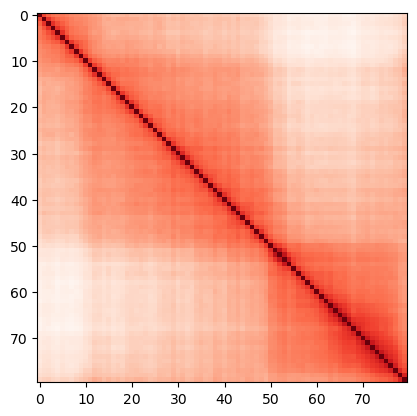

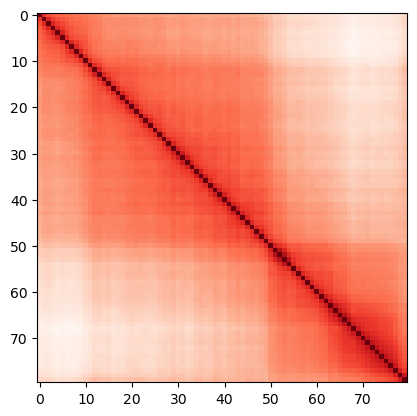

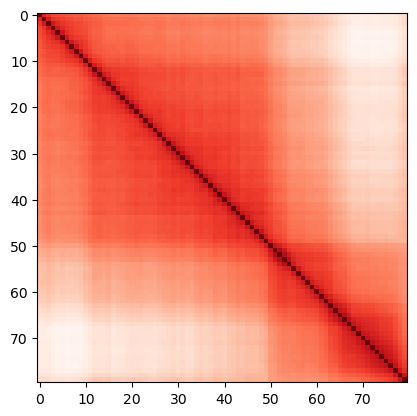

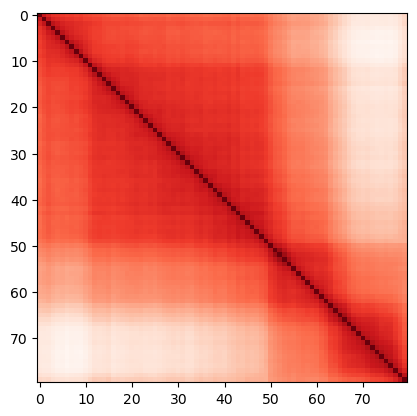

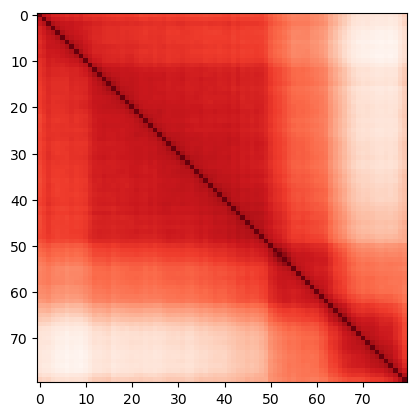

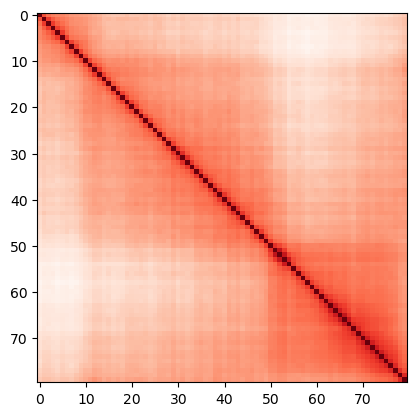

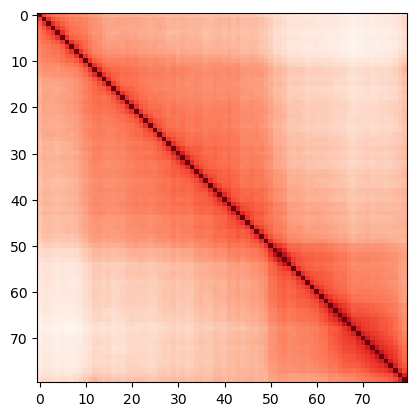

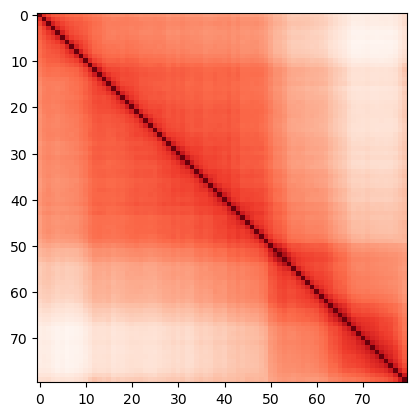

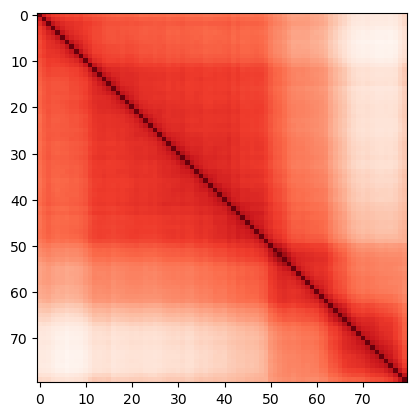

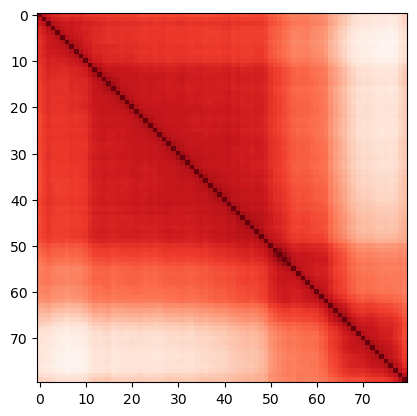

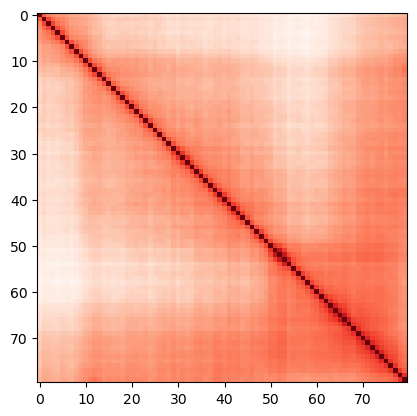

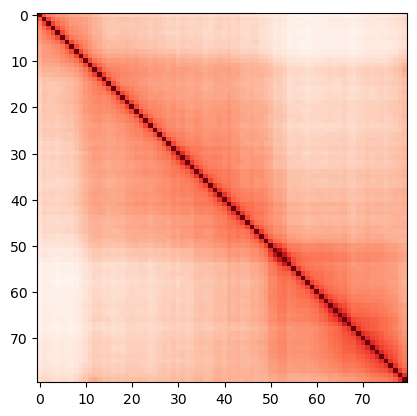

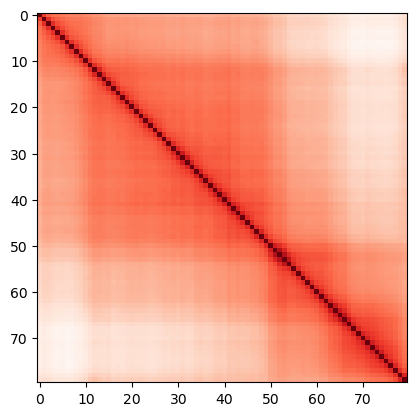

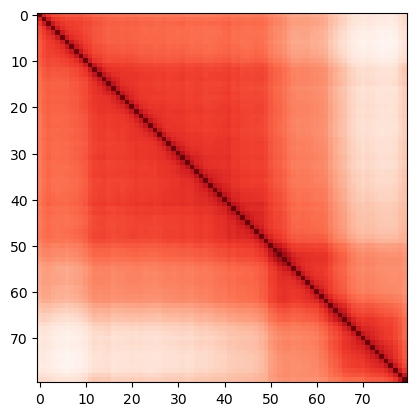

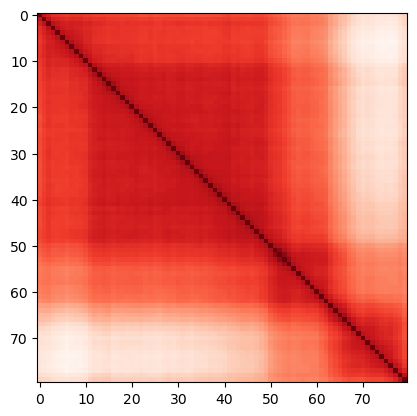

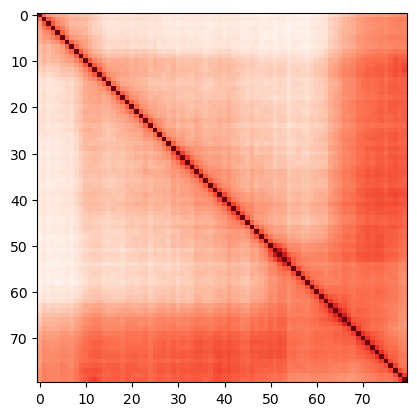

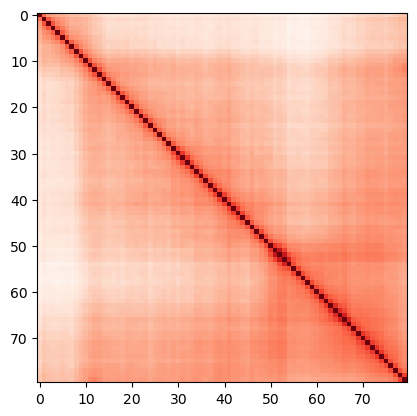

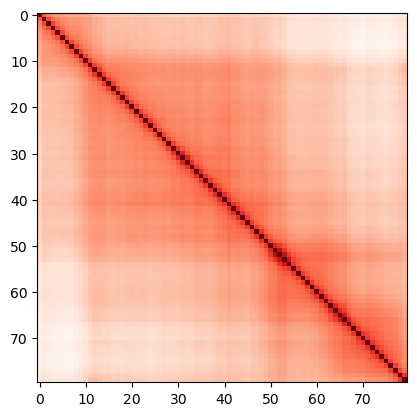

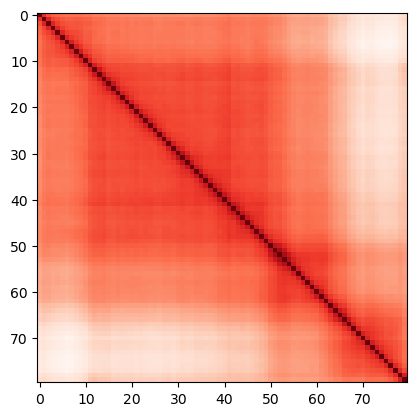

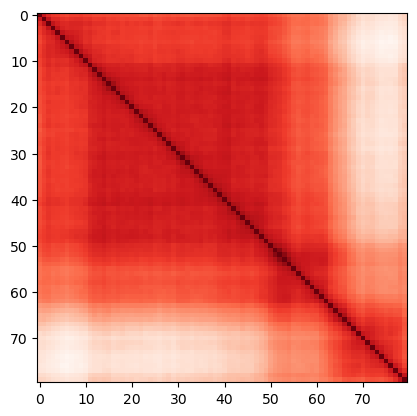

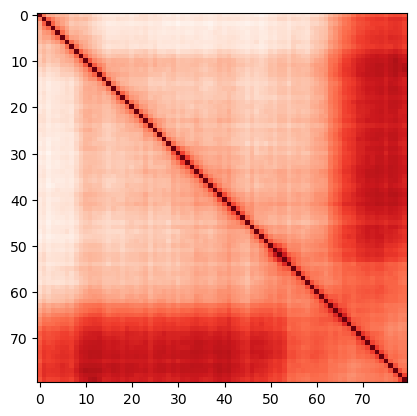

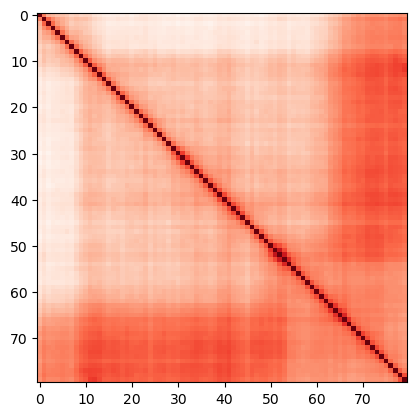

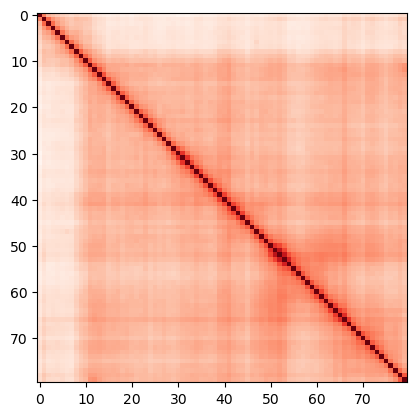

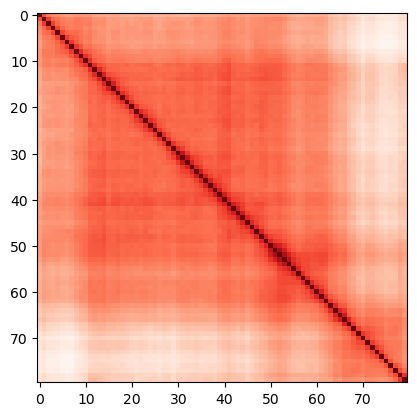

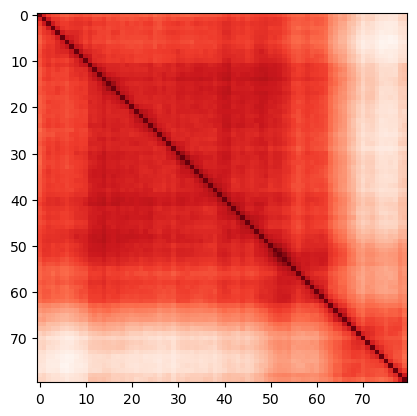

In [27]:
for x in metastr_from_pca:
    plt.imshow(x.reshape(80, 80), cmap='Reds_r')
    plt.show()

In [2]:
common_dir = '/mnt/home/tudomlumleart/ceph/01_ChromatinEnsembleRefinement/chromatin-ensemble-refinement/MCMC_results/20240912_RunWeightMCMC_Sox9_PCA_utilsV4'
stan_directory_esc = os.path.join(common_dir, 'ESC/stan_output')
stan_directory_cnc = os.path.join(common_dir, 'CNC/stan_output')

In [3]:
esc_log_weights = load_weights(stan_directory_esc, 25)
cnc_log_weights = load_weights(stan_directory_cnc, 25)

esc_weights_all = np.exp(np.array(esc_log_weights))
cnc_weights_all = np.exp(np.array(cnc_log_weights))

esc_weights_all = esc_weights_all.reshape(-1, 25)
cnc_weights_all = cnc_weights_all.reshape(-1, 25)

esc_entropy_all = np.array([scipy.stats.entropy(x) for x in esc_weights_all])
cnc_entropy_all = np.array([scipy.stats.entropy(x) for x in cnc_weights_all])

# Put these data in dataframe 
esc_entropy_df = pd.DataFrame({'entropy': esc_entropy_all, 'label': 'ESC'})
cnc_entropy_df = pd.DataFrame({'entropy': cnc_entropy_all, 'label': 'NPC'})

all_entropy_df = pd.concat([esc_entropy_df, cnc_entropy_df], axis=0)

['20240715_WeightOptimization-20240920165648_1.csv', '20240715_WeightOptimization-20240920165648_2.csv', '20240715_WeightOptimization-20240920165648_3.csv', '20240715_WeightOptimization-20240920165648_4.csv']
['20240715_WeightOptimization-20240920165700_1.csv', '20240715_WeightOptimization-20240920165700_2.csv', '20240715_WeightOptimization-20240920165700_3.csv', '20240715_WeightOptimization-20240920165700_4.csv']


In [5]:
import matplotlib

esc_weights = np.mean(np.exp(np.array(esc_log_weights)), axis=(0, 1))
cnc_weights = np.mean(np.exp(np.array(cnc_log_weights)), axis=(0, 1))

# Put weights in a DataFrame
esc_weights_df = pd.DataFrame({'PC1': pc1_pc2_df['PC1'].values,
                               'PC2': pc1_pc2_df['PC1'].values,  
                               'weight': esc_weights})
esc_weights_df['label'] = 'ESC'
cnc_weights_df = pd.DataFrame({'PC1': pc1_pc2_df['PC1'].values,
                               'PC2': pc1_pc2_df['PC1'].values, 
                               'weight': cnc_weights})
cnc_weights_df['label'] = 'CNC'

In [6]:
save_dir = '/mnt/home/tudomlumleart/ceph/01_ChromatinEnsembleRefinement/chromatin-ensemble-refinement/figures/20240917'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

In [13]:
import matplotlib.colors as mcolors

# Create a logarithmic normalization
norm = mcolors.LogNorm(vmin=esc_weights_df['weight'].values.min(), vmax=esc_weights_df['weight'].values.max())

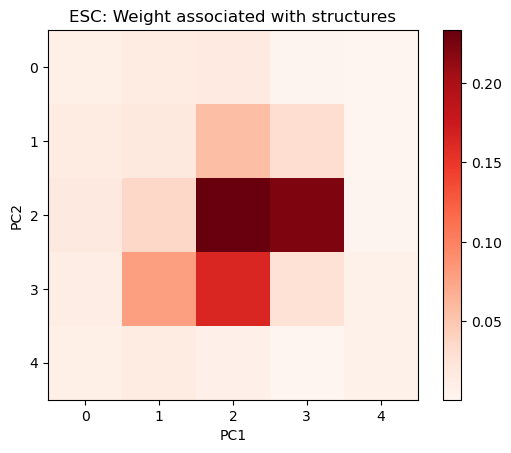

In [7]:
plt.imshow(esc_weights_df['weight'].values.reshape(5, 5).T,
           cmap='Reds')
# set xticks 
# xlabel = np.array([f"{x:.1e}" for x in esc_weights_df['PC1'].unique()])[::10]
# ylabel = np.array([f"{x:.1e}" for x in esc_weights_df['PC2'].unique()])[::-10]
# plt.xticks(np.arange(0, 50, 10), xlabel, rotation=45)
# plt.yticks(np.arange(0, 50, 10), ylabel, rotation=45)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('ESC: Weight associated with structures')
plt.colorbar()
# plt.savefig(os.path.join(save_dir, 'esc_weights_50x50.png'), dpi=300, bbox_inches='tight')

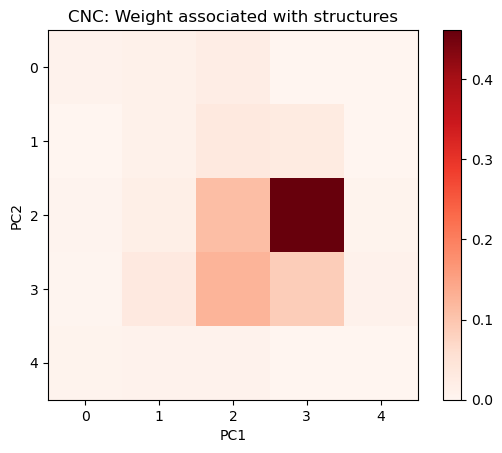

In [8]:
plt.imshow(cnc_weights_df['weight'].values.reshape(5, 5).T,
           cmap='Reds', vmin=0)
# set xticks 
# xlabel = np.array([f"{x:.1e}" for x in cnc_weights_df['PC1'].unique()])[::10]
# ylabel = np.array([f"{x:.1e}" for x in cnc_weights_df['PC2'].unique()])[::-10]
# plt.xticks(np.arange(0, 50, 10), xlabel, rotation=45)
# plt.yticks(np.arange(0, 50, 10), ylabel, rotation=45)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('CNC: Weight associated with structures')
plt.colorbar()
# plt.savefig(os.path.join(save_dir, 'cnc_weights_50x50.png'), dpi=300, bbox_inches='tight')